In [1]:
# Kernel 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
nltk.download('punkt')

c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Richie.teoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Kernel 2: Obtaining Dataset and Creating 'Class' Column
dataset = load_dataset('sms_spam')['train']
sms = pd.DataFrame(dataset)
sms['Class'] = np.where(sms.label == 1, 'Spam', 'Ham')
display(sms.head())

,sms,label,Class
0,"Go until jurong point, crazy.. Available only ...",0,Ham
1,Ok lar... Joking wif u oni...\n,0,Ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Spam
3,U dun say so early hor... U c already then say...,0,Ham
4,"Nah I don't think he goes to usf, he lives aro...",0,Ham


sms      0
label    0
Class    0
dtype: int64


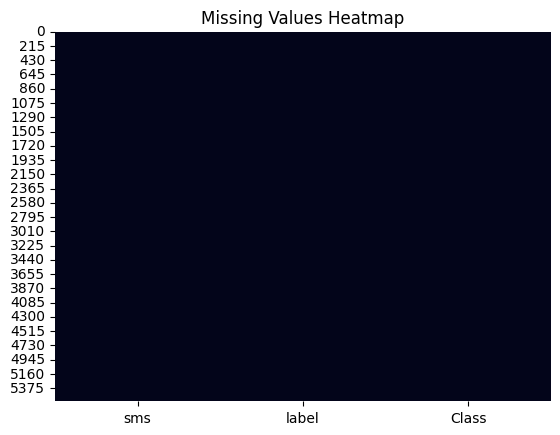

np.int64(403)

np.int64(0)

In [3]:
# Kernel 3: Scrubbing the Data
# Check and visualize missing values
print(sms.isnull().sum())
sns.heatmap(sms.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Check for duplicated values
display(sms.duplicated().sum())

# Remove the duplicates
sms = sms.drop_duplicates(keep="first").reset_index(drop=True)

# Verify the number of duplicates after removal
display(sms.duplicated().sum())

# Add basic text-based features
sms['Num_char'] = sms['sms'].apply(len)
sms['Num_words'] = sms['sms'].apply(lambda x: len(nltk.word_tokenize(x)))
sms['Num_sentences'] = sms['sms'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [15]:
# Kernel 4: Scrubbing Branch 1 - TF-IDF Vectorization
import joblib
vectorizer = TfidfVectorizer(
    lowercase=True,             
    stop_words='english',       
    ngram_range=(1, 2),         # Unigrams + Bigrams
    max_df=0.9,                 
    min_df=3,                   # Slightly lower to keep informative rare phrases
    max_features=4000,          # Optional: reduce dimensionality
    sublinear_tf=True           
)
X_tfidf = vectorizer.fit_transform(sms['sms'])
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [5]:
# Kernel 5: Scrubbing Branch 2 - BERT Embeddings
import os 

if os.path.exists("bert_sms_embeddings.npy"):
    print("Found cached BERT embeddings. Loading from file...")
    X_bert = np.load("bert_sms_embeddings.npy")
else:
    print("First-time user. Extracting now...")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")
    model.eval()

    def extract_cls_embeddings(texts):
        embeddings = []
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            with torch.no_grad():
                outputs = model(**inputs)
            cls_vec = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_vec)
        return np.array(embeddings)

    X_bert = extract_cls_embeddings(sms['sms'])
    np.save("bert_sms_embeddings.npy", X_bert)

Found cached BERT embeddings. Loading from file...


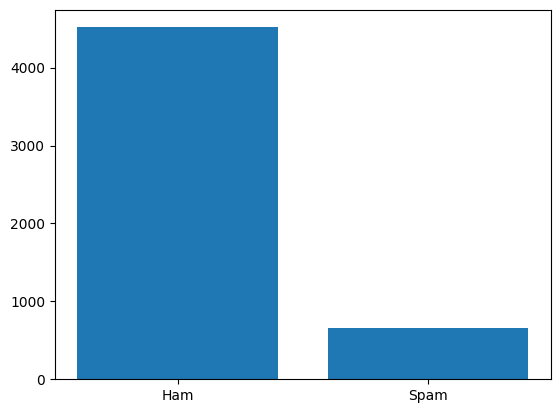

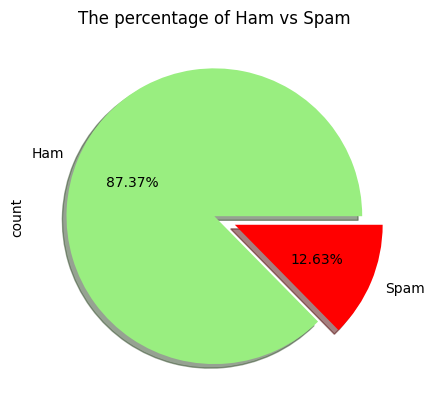

Class Ratio:  0.12628


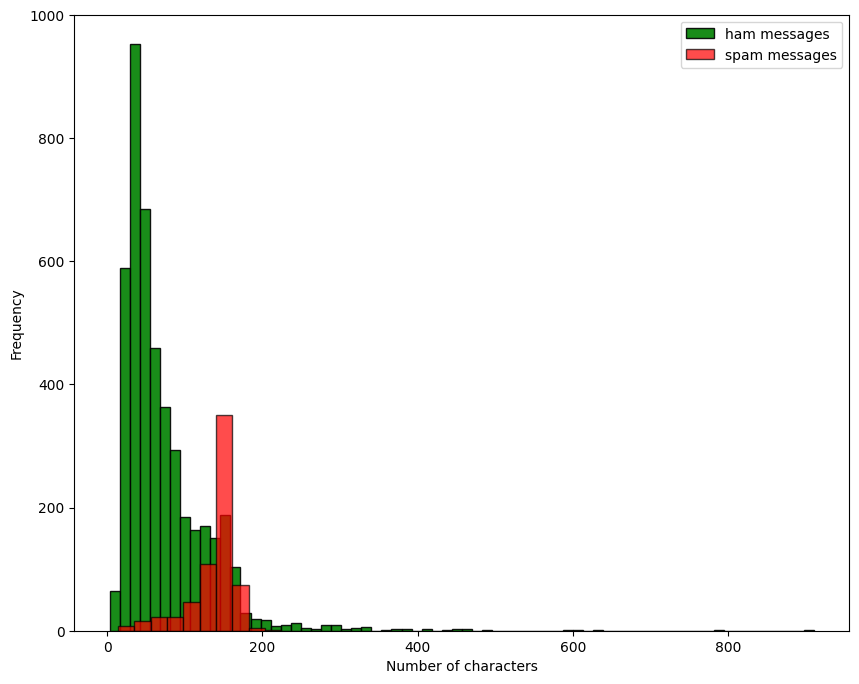

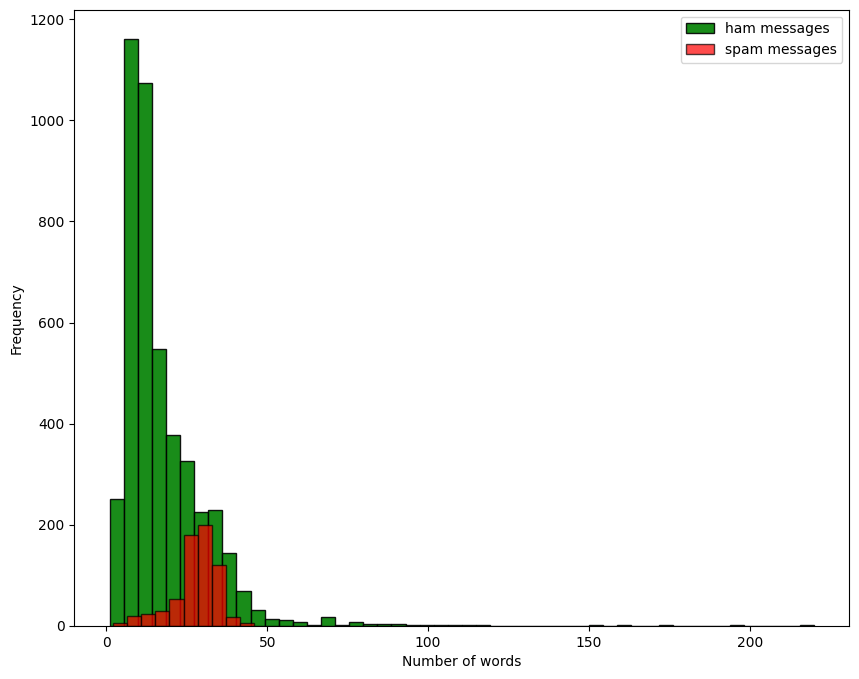

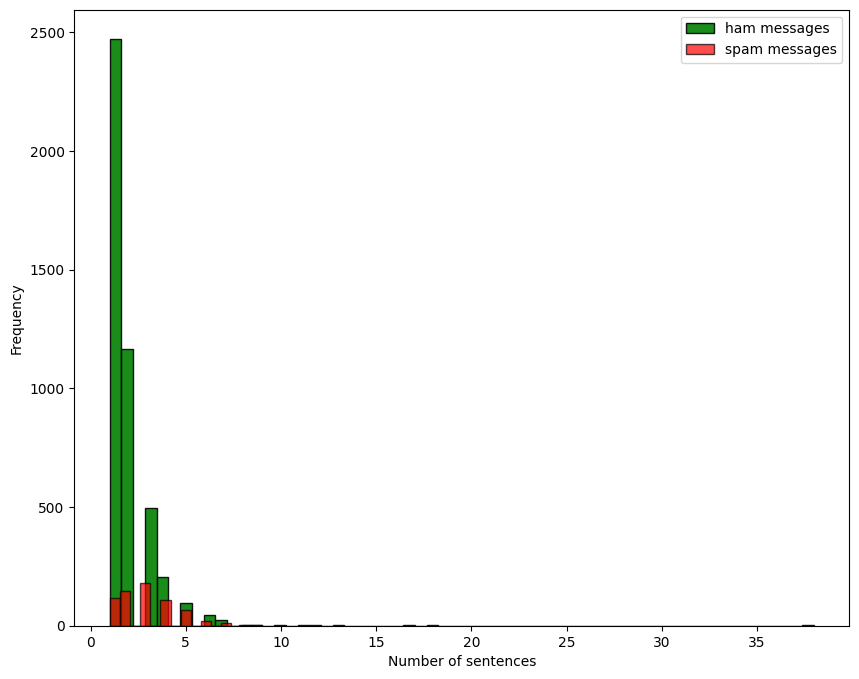

-----------------------------------


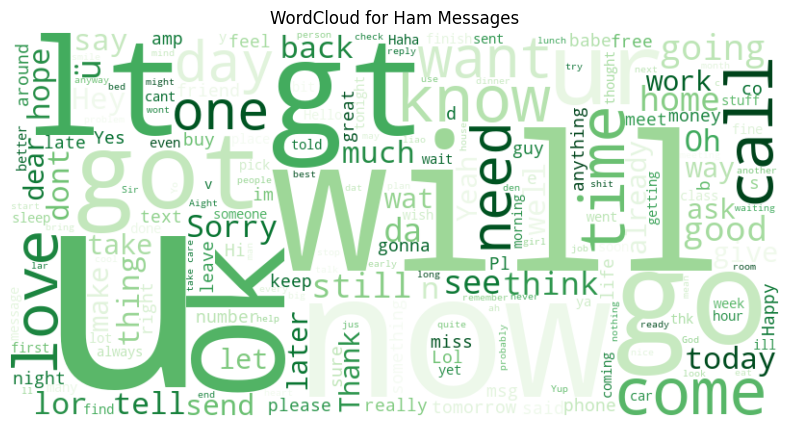

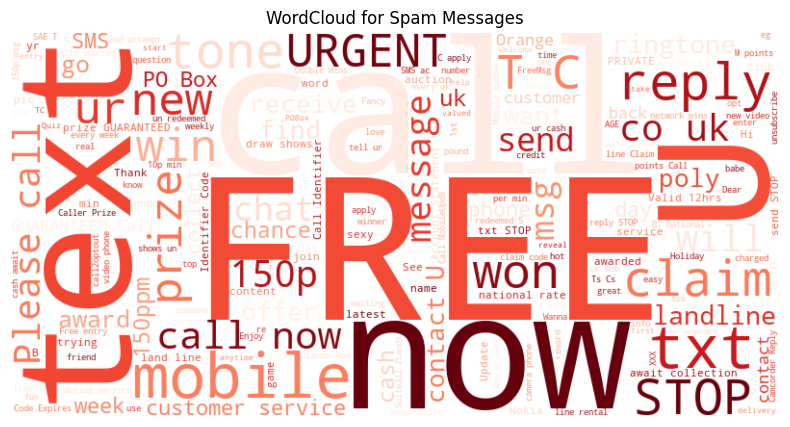

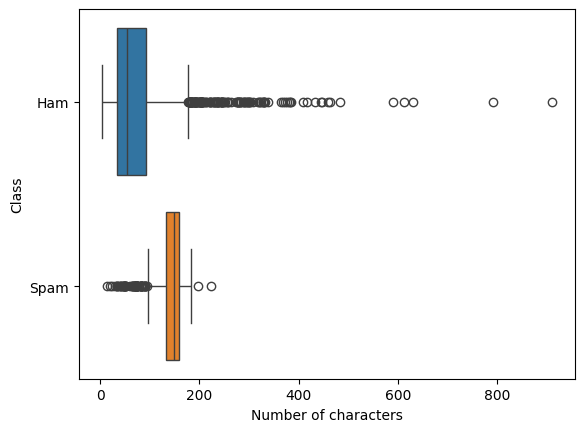

<Figure size 1600x1200 with 0 Axes>

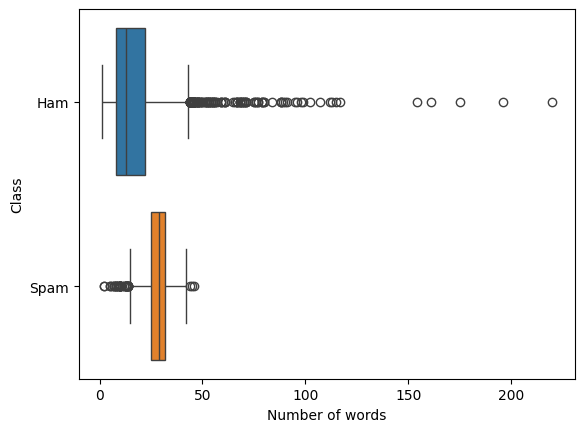

<Figure size 1600x1200 with 0 Axes>

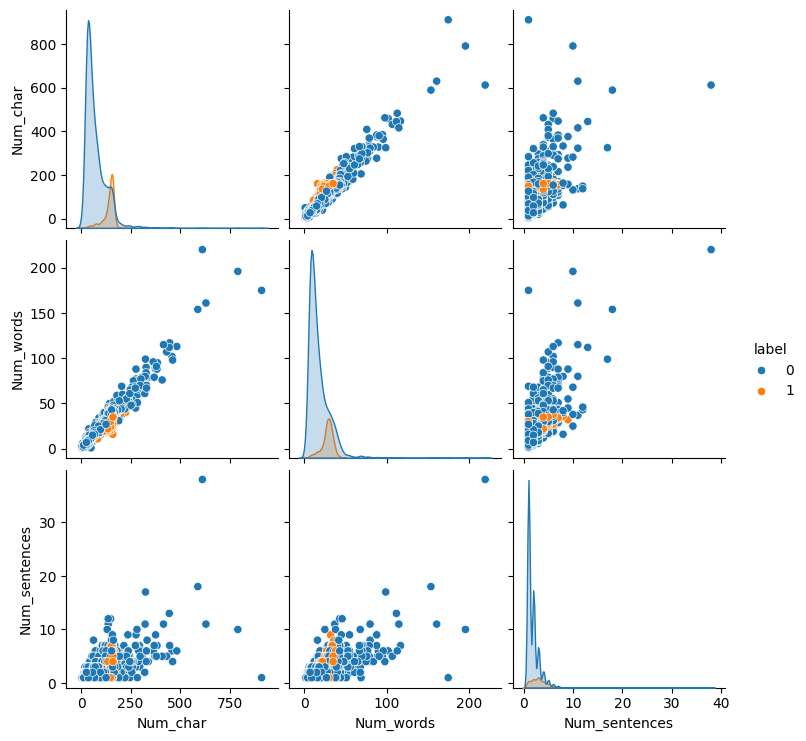

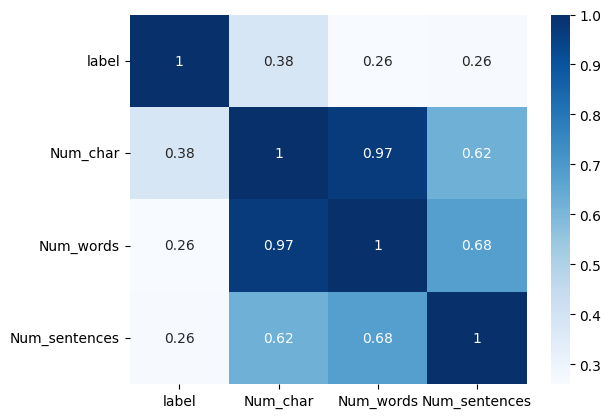

In [6]:
# Kernel 6: EDA General
# bar plot to look at the frequency of the label
class_counts = sms['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.show()

# pie chart to have a better visualisation
sms["Class"].value_counts().plot(kind="pie", labels=["Ham", "Spam"], colors=["#99ee80", "red"],
                                 autopct="%0.2f%%", explode=(0, 0.15), shadow=True)
plt.title("The percentage of Ham vs Spam")
plt.show()


# checking whether data is imbalance
class_ratio = sum(sms["label"]) / len(sms["label"])
print("Class Ratio: ",round(class_ratio, 5))


# Using histogram to visualise the distribution of data with respect to each parameter
# number of characters
plt.figure(figsize = (10, 8))
sms_ham = sms[ sms["Class"] == "Ham" ]["Num_char"]
sms_spam = sms[ sms["Class"] == "Spam" ]["Num_char"]

sms_ham.plot(bins=70, kind="hist", color="green",
             label="ham messages", alpha=0.9, edgecolor="black")
sms_spam.plot(kind="hist", color="red",
              label="spam messages", alpha=0.7, edgecolor="black")

plt.legend()
plt.xlabel("Number of characters")
plt.show()


# number of words
plt.figure(figsize = (10, 8))

sms[ sms["Class"] == "Ham" ]["Num_words"].plot(bins=50, kind="hist", color="green", label="ham messages",
                                              alpha=0.9, edgecolor="black")
sms[ sms["Class"] == "Spam" ]["Num_words"].plot(kind="hist", color="red", label="spam messages",
                                               alpha=0.7, edgecolor="black")

plt.legend()
plt.xlabel("Number of words")
plt.show()


# number of sentences
plt.figure(figsize = (10, 8))

sms[ sms["Class"] == "Ham" ]["Num_sentences"].plot(bins=60, kind="hist", color="green", label="ham messages",
                                                   alpha=0.9, edgecolor="black")
sms[ sms["Class"] == "Spam" ]["Num_sentences"].plot(bins=15, kind="hist", color="red", label="spam messages",
                                                    alpha=0.7, edgecolor="black")
plt.legend()
plt.xlabel("Number of sentences")
plt.show()
print("-----------------------------------")

# WordCloud 
from wordcloud import WordCloud
# Join all tokenized words for Ham and Spam
ham_words = ' '.join(sms[sms['Class'] == 'Ham']['sms'])
spam_words = ' '.join(sms[sms['Class'] == 'Spam']['sms'])

# WordCloud for Ham
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_words)
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Ham Messages')
plt.show()

# WordCloud for Spam
spam_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_words)
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Spam Messages')
plt.show()

# boxplot to view the distribution and outliers involved
fig, ax = plt.subplots(1, 1)
plt.figure(figsize=(16, 12))

sns.boxplot(x=sms["Num_char"], y=sms["Class"], data=sms, hue="Class", ax=ax)
ax.set(xlabel="Number of characters")

plt.show()


fig, ax = plt.subplots(1, 1)
plt.figure(figsize=(16, 12))

sns.boxplot(x=sms["Num_words"], y=sms["Class"], data=sms, hue="Class", ax=ax)
ax.set(xlabel="Number of words")

plt.show()


# To have a better understanding on data
sns.pairplot(sms, hue="label")

plt.show()


# Correlation to view the relationship between parameters

# Only keep numeric columns
numeric_sms = sms.select_dtypes(include='number')

# Plot correlation heatmap
sns.heatmap(numeric_sms.corr(), annot=True, cmap="Blues")
plt.show()

         word     score
1185     free  0.040254
3189      txt  0.030016
3021     text  0.027890
2902     stop  0.027403
2036   mobile  0.027103
669     claim  0.025311
2566    reply  0.024491
3510      www  0.022199
2446    prize  0.021727
3242       ur  0.021062
2155      new  0.020687
3211       uk  0.019690
89       150p  0.017650
3474      won  0.017371
2716  service  0.017056
706       com  0.016255
3274   urgent  0.016193
598      cash  0.015917
3444      win  0.014784
2693     send  0.014547
       word     score
2238     ok  0.017562
1651   just  0.014003
710    come  0.013733
1811     ll  0.013132
1352     gt  0.012848
1321    got  0.012843
1782   like  0.012796
1903     lt  0.012768
1699   know  0.012678
1301   good  0.012573
3076   time  0.011666
1905  lt gt  0.011661
1289  going  0.011108
1483   home  0.010781
3372   want  0.010272
837      da  0.010169
1861    lor  0.010075
3242     ur  0.009648
2134   need  0.009549
1879   love  0.009149


c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


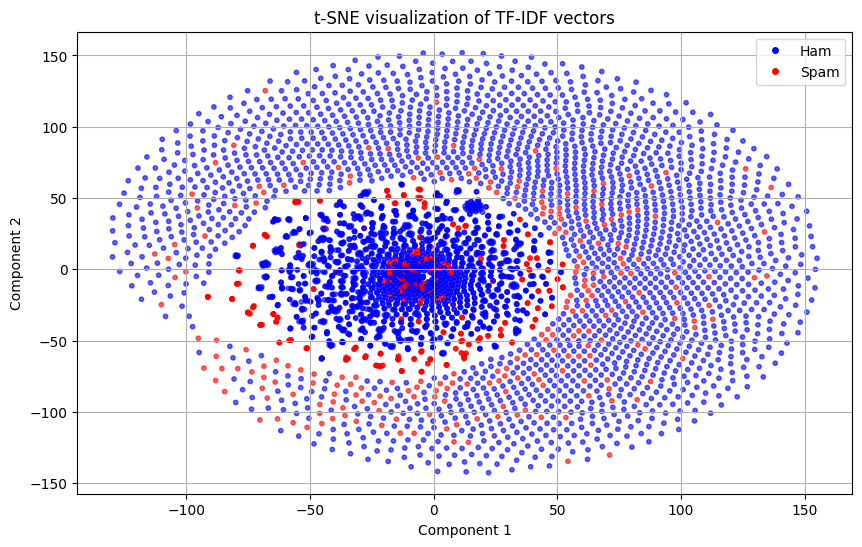

In [7]:
# Kernel 7: EDA Branch 1 
# 1. Separate spam and ham indexes and features
spam_idx = sms[sms['Class'] == 'Spam'].index
ham_idx = sms[sms['Class'] == 'Ham'].index
features = vectorizer.get_feature_names_out()

# 2. Get spam and ham tf-idf submatrices
X_spam = X_tfidf[spam_idx]
X_ham = X_tfidf[ham_idx]

# 3. Mean TF-IDF per word
spam_mean = X_spam.mean(axis=0).A1
ham_mean = X_ham.mean(axis=0).A1

# 4. Score (spam)
word_score_spam = pd.DataFrame({'word': features, 'score': spam_mean})
top_words_spam = word_score_spam.sort_values(by='score', ascending=False).head(20)

# 5. Score (ham)
word_score_ham = pd.DataFrame({'word': features, 'score': ham_mean})
top_words_ham = word_score_ham.sort_values(by='score', ascending=False).head(20)

# 6. Show top words
print(top_words_spam)
print(top_words_ham)

# 7. Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000)
X_embedded = tsne.fit_transform(X_tfidf.toarray())

# 8. Plot
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 'Ham' else 'red' for label in sms['Class']]
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, alpha=0.6, s=10)
plt.title("t-SNE visualization of TF-IDF vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Ham', markerfacecolor='blue', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='Spam', markerfacecolor='red', markersize=6)
])
plt.grid(True)
plt.show()

c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


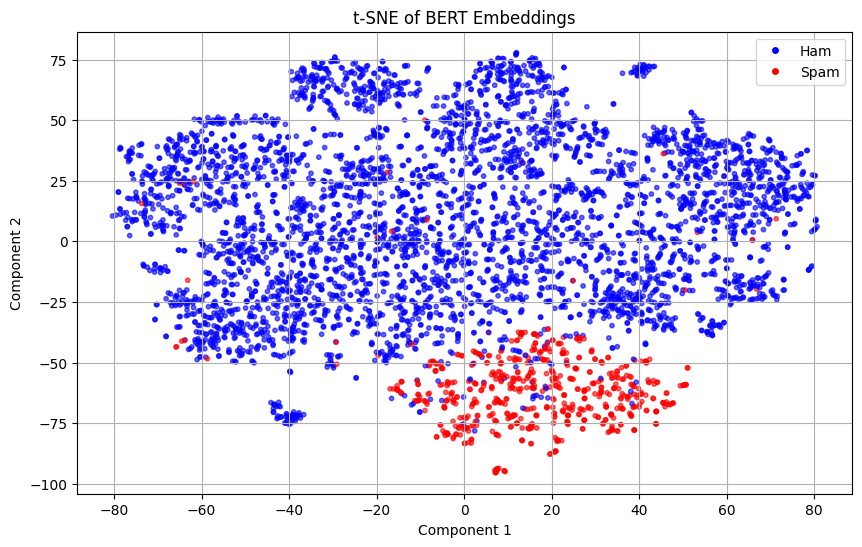

In [8]:
# Kernel 8: EDA Branch 2 - BERT t-SNE
X_bert = np.load('bert_sms_embeddings.npy')
y = np.load('bert_sms_labels.npy')

tsne_bert = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_bert)
plt.figure(figsize=(10, 6))
colors = ['red' if label == 1 else 'blue' for label in y]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, s=10)

plt.title("t-SNE of BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Ham', markerfacecolor='blue', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='Spam', markerfacecolor='red', markersize=6)
])
plt.grid(True)
plt.show()

In [9]:
# Kernel 9: Modelling (Train/Validation/Test split)

from sklearn.model_selection import train_test_split, StratifiedKFold
import torch 

# 70% Train, 30% Test (Set seed = 7001 (from WQD7001) for reproducible results)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=7001, stratify=y)
X_train_bert, X_test_bert = train_test_split(X_bert, test_size=0.3, random_state=7001, stratify=y)

# Set-up StratifiedKFold 
cv = StratifiedKFold(n_splits=5,
                     shuffle = True,
                     random_state = 7001)

# Converting numpy arrays to torch tensors for Neural Network Deeplearning models
X_train_bert_tensor = torch.tensor(X_train_bert, dtype = torch.float32)
X_test_bert_tensor = torch.tensor(X_test_bert, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32).unsqueeze(1)

In [10]:
# Kernel 10: Initialize models

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import torch.nn as nn 
import torch.optim as optim

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
}

class MLPClassifier_torch(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, dropout_rate):
        super(MLPClassifier_torch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim,hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim2,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
        
# Initialize model, loss, optimizer
MLP_model = MLPClassifier_torch(input_dim = X_train_bert_tensor.shape[1], hidden_dim = 128, hidden_dim2= 64, dropout_rate=0.3)
criterion = nn.BCELoss()
optimizer = optim.Adam(MLP_model.parameters(), lr=0.001)

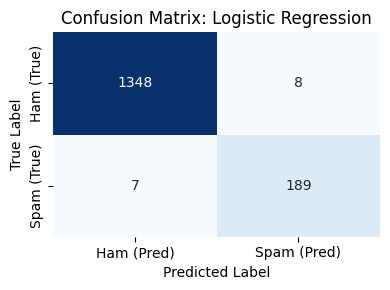

The best model, LR dumped into .pkl file!!!


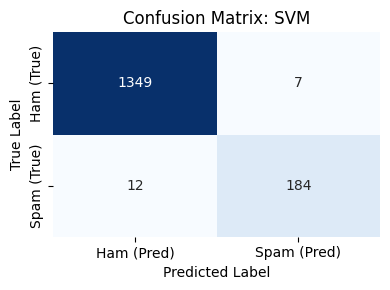

c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:31:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


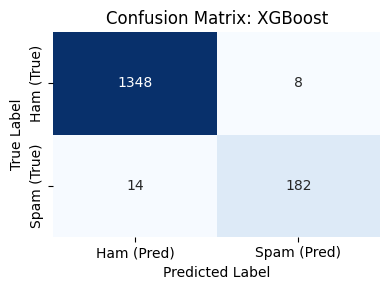

,Model,Accuracy,Precision,Recall,F1 Score,F1 Macro,ROC AUC
0,Logistic Regression,0.990335,0.959391,0.964286,0.961832,0.978150,0.997133
1,SVM,0.987758,0.963351,0.938776,0.950904,0.971956,0.995191
2,XGBoost,0.985825,0.957895,0.928571,0.943005,0.967455,0.994236


Epoch 1, Loss: 0.7677
Epoch 2, Loss: 0.6826
Epoch 3, Loss: 0.6175
Epoch 4, Loss: 0.5607
Epoch 5, Loss: 0.5072
Epoch 6, Loss: 0.4569
Epoch 7, Loss: 0.4141
Epoch 8, Loss: 0.3863
Epoch 9, Loss: 0.3632
Epoch 10, Loss: 0.3577
Epoch 11, Loss: 0.3578
Epoch 12, Loss: 0.3626
Epoch 13, Loss: 0.3577
Epoch 14, Loss: 0.3470
Epoch 15, Loss: 0.3370
Epoch 16, Loss: 0.3165
Epoch 17, Loss: 0.3006
Epoch 18, Loss: 0.2815
Epoch 19, Loss: 0.2682
Epoch 20, Loss: 0.2555


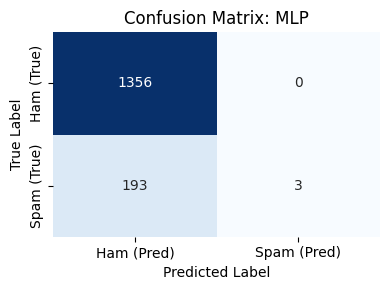

,Model,Accuracy,Precision,Recall,F1 Score,F1 Macro,ROC AUC
0,Logistic Regression,0.990335,0.959391,0.964286,0.961832,0.978150,0.997133
1,SVM,0.987758,0.963351,0.938776,0.950904,0.971956,0.995191
2,XGBoost,0.985825,0.957895,0.928571,0.943005,0.967455,0.994236
3,MLP,0.875644,1.000000,0.015306,0.030151,0.481857,0.981183


In [11]:
# Kernel 11: Train models without hyperparameter tuning
from sklearn.metrics import confusion_matrix
import joblib

results = []

# sklearn models
for name, model in models.items():
    model.fit(X_train_bert, y_train)
    preds = model.predict(X_test_bert)
    probs = model.predict_proba(X_test_bert)[:, 1]

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham (Pred)', 'Spam (Pred)'],
                yticklabels=['Ham (True)', 'Spam (True)'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "F1 Macro": f1_score(y_test, preds, average= 'macro' ),
        "ROC AUC": roc_auc_score(y_test, probs)
    })

    if name == 'Logistic Regression':
        joblib.dump(model, 'best_lr_model.pkl')
        print('The best model, LR dumped into .pkl file!!!')

# Save as DataFrame
metrics_df = pd.DataFrame(results)
display(metrics_df)


# pytorch MLP model
# Training - MLP
MLP_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    outputs = MLP_model(X_train_bert_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluation - MLP
MLP_model.eval()
with torch.no_grad():
    mlp_probs = MLP_model(X_test_bert_tensor).numpy()
    mlp_preds = (mlp_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ham (Pred)', 'Spam (Pred)'],
            yticklabels=['Ham (True)', 'Spam (True)'])
plt.title("Confusion Matrix: MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Append MLP metrics
results.append({
    "Model": "MLP",
    "Accuracy": accuracy_score(y_test, mlp_preds),
    "Precision": precision_score(y_test, mlp_preds),
    "Recall": recall_score(y_test, mlp_preds),
    "F1 Score": f1_score(y_test, mlp_preds),
    "F1 Macro": f1_score(y_test, mlp_preds, average= 'macro' ),
    "ROC AUC": roc_auc_score(y_test, mlp_probs)
})

# Display all results
metrics_df = pd.DataFrame(results)
display(metrics_df)


 Tuning Logistic Regression...


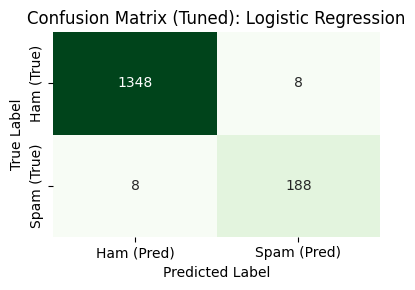


 Tuning SVM...


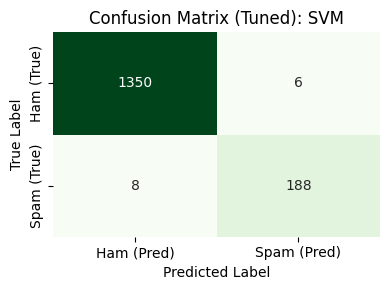


 Tuning XGBoost...


c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:33:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


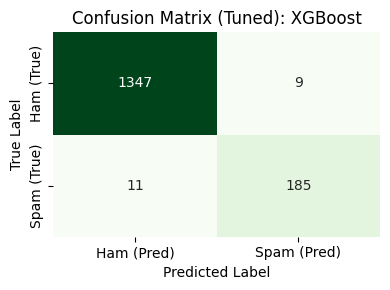

,Model,Accuracy,Precision,Recall,F1 Score,F1 Macro,ROC AUC
0,Logistic Regression,0.990335,0.959391,0.964286,0.961832,0.978150,0.997133
1,SVM,0.987758,0.963351,0.938776,0.950904,0.971956,0.995191
2,XGBoost,0.985825,0.957895,0.928571,0.943005,0.967455,0.994236
3,MLP,0.875644,1.000000,0.015306,0.030151,0.481857,0.981183
4,Logistic Regression (Tuned),0.989691,0.959184,0.959184,0.959184,0.976642,0.997103
5,SVM (Tuned),0.990979,0.969072,0.959184,0.964103,0.979472,0.998593
6,XGBoost (Tuned),0.987113,0.953608,0.943878,0.948718,0.970674,0.995376


In [12]:
# Kernel 12: Tuning Hyperparameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Parameter Grid
param_grid = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }
}


# K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7001)


# Grid search and evaluation
for name, model in models.items():
    print(f"\n Tuning {name}...")

    grid = GridSearchCV(
        model,
        param_grid[name],
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid.fit(X_train_bert, y_train)

    best_model = grid.best_estimator_          
    best_preds = best_model.predict(X_test_bert)
    best_probs = best_model.predict_proba(X_test_bert)[:, 1]

    cm = confusion_matrix(y_test, best_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Ham (Pred)', 'Spam (Pred)'],
                yticklabels=['Ham (True)', 'Spam (True)'])
    plt.title(f"Confusion Matrix (Tuned): {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Append to results
    results.append({
        "Model": name + " (Tuned)",
        "Accuracy": accuracy_score(y_test, best_preds),
        "Precision": precision_score(y_test, best_preds),
        "Recall": recall_score(y_test, best_preds),
        "F1 Score": f1_score(y_test, best_preds),
        "F1 Macro": f1_score(y_test, best_preds, average= 'macro' ),
        "ROC AUC": roc_auc_score(y_test, best_probs)
    })

# Final display
metrics_df = pd.DataFrame(results)
display(metrics_df)

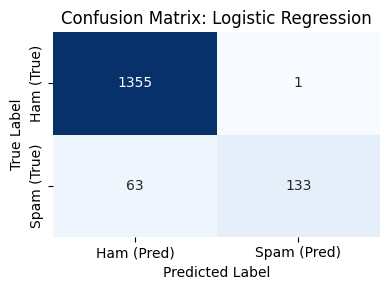

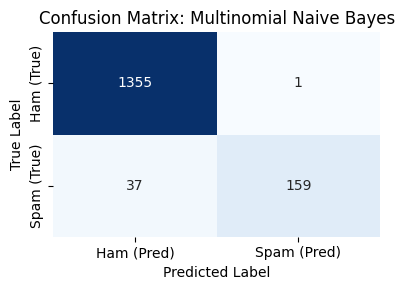

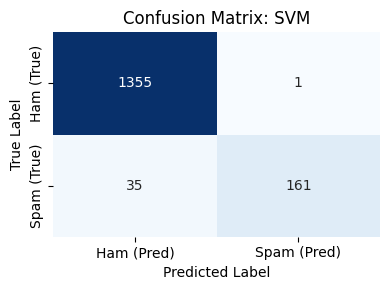

c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


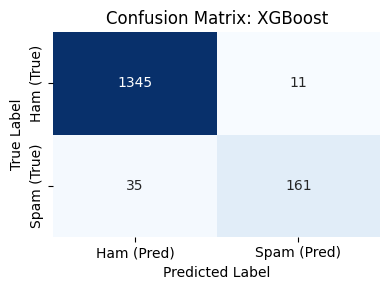

,Model,Accuracy,Precision,Recall,F1 Score,F1 Macro,ROC AUC
0,Logistic Regression,0.990335,0.959391,0.964286,0.961832,0.978150,0.997133
1,SVM,0.987758,0.963351,0.938776,0.950904,0.971956,0.995191
2,XGBoost,0.985825,0.957895,0.928571,0.943005,0.967455,0.994236
3,MLP,0.875644,1.000000,0.015306,0.030151,0.481857,0.981183
4,Logistic Regression (Tuned),0.989691,0.959184,0.959184,0.959184,0.976642,0.997103
5,SVM (Tuned),0.990979,0.969072,0.959184,0.964103,0.979472,0.998593
6,XGBoost (Tuned),0.987113,0.953608,0.943878,0.948718,0.970674,0.995376
7,Logistic Regression (TF-IDF),0.958763,0.992537,0.678571,0.806061,0.891495,0.988515
8,Multinomial Naive Bayes (TF-IDF),0.975515,0.993750,0.811224,0.893258,0.939715,0.988146
9,SVM (TF-IDF),0.976804,0.993827,0.821429,0.899441,0.943166,0.989388


In [13]:
# Define models
from sklearn.naive_bayes import MultinomialNB

models_tfidf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
}

for name, model in models_tfidf.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    probs = model.predict_proba(X_test_tfidf)[:, 1]

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot = True, fmt = 'd', cmap = 'Blues', cbar = False,
        xticklabels=['Ham (Pred)', 'Spam (Pred)'],
        yticklabels=['Ham (True)', 'Spam (True)']
    )
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    results.append({
        'Model': f"{name} (TF-IDF)",
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds),
        'F1 Macro': f1_score(y_test, preds, average = 'macro'),
        'ROC AUC': roc_auc_score(y_test, probs)
    })

metrics_df = pd.DataFrame(results)
display(metrics_df)    


 Tuning Logistic Regression...


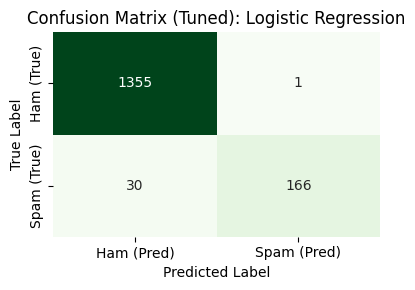


 Tuning SVM...


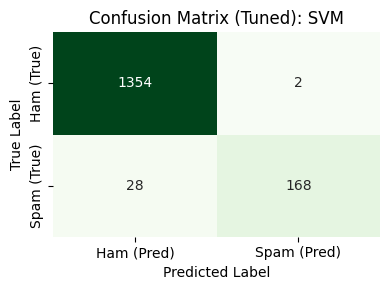


 Tuning XGBoost...


c:\Users\Richie.teoh\Downloads\UM\WQD7001\Assignment\project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


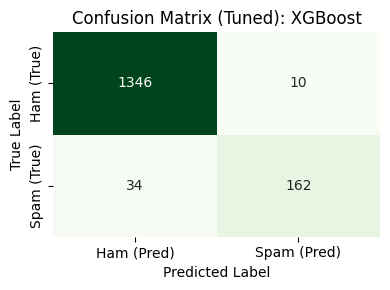

,Model,Accuracy,Precision,Recall,F1 Score,F1 Macro,ROC AUC
0,Logistic Regression,0.990335,0.959391,0.964286,0.961832,0.978150,0.997133
1,SVM,0.987758,0.963351,0.938776,0.950904,0.971956,0.995191
2,XGBoost,0.985825,0.957895,0.928571,0.943005,0.967455,0.994236
3,MLP,0.875644,1.000000,0.015306,0.030151,0.481857,0.981183
4,Logistic Regression (Tuned),0.989691,0.959184,0.959184,0.959184,0.976642,0.997103
5,SVM (Tuned),0.990979,0.969072,0.959184,0.964103,0.979472,0.998593
6,XGBoost (Tuned),0.987113,0.953608,0.943878,0.948718,0.970674,0.995376
7,Logistic Regression (TF-IDF),0.958763,0.992537,0.678571,0.806061,0.891495,0.988515
8,Multinomial Naive Bayes (TF-IDF),0.975515,0.993750,0.811224,0.893258,0.939715,0.988146
9,SVM (TF-IDF),0.976804,0.993827,0.821429,0.899441,0.943166,0.989388


In [ ]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7001)

# Param grid for each model
param_grid_tfidf = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    },
    'Multinomial Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0]  # Laplace smoothing parameter
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
}

# Grid search and evaluation
for name, model in models.items():
    print(f"\n Tuning {name}...")

    grid = GridSearchCV(
        model,
        param_grid[name],
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid.fit(X_train_tfidf, y_train)

    best_model = grid.best_estimator_          
    best_preds = best_model.predict(X_test_tfidf)
    best_probs = best_model.predict_proba(X_test_tfidf)[:, 1]

    cm = confusion_matrix(y_test, best_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Ham (Pred)', 'Spam (Pred)'],
                yticklabels=['Ham (True)', 'Spam (True)'])
    plt.title(f"Confusion Matrix (Tuned): {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Append to results
    results.append({
        "Model": name + " (TF-IDF Tuned)",
        "Accuracy": accuracy_score(y_test, best_preds),
        "Precision": precision_score(y_test, best_preds),
        "Recall": recall_score(y_test, best_preds),
        "F1 Score": f1_score(y_test, best_preds),
        "F1 Macro": f1_score(y_test, best_preds, average= 'macro' ),
        "ROC AUC": roc_auc_score(y_test, best_probs)
    })

    if name == 'SVM':
    joblib.dump(model, 'best_svm_model.pkl')
    print('The best model, SVM dumped into .pkl file!!!')


# Final display
metrics_df = pd.DataFrame(results)
display(metrics_df)